![Semillero Astrofisica](logo.PNG)

---
## Ejemplo: Ecuación Integrodiferencial


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la siguiente ecuación integro diferencial:

\begin{equation}
    \frac{\partial}{\partial t}u(t)+2u(t)+5\int_0^tu(x)dx=1\qquad t\in[0,2]
\end{equation}

\begin{equation}
    u(0)=0
\end{equation}

La solución analítica de esta ecuación es 
\begin{equation}
    u(t)=\frac{1}{2}e^{-t}\sin{2t}
\end{equation}

In [1]:
using NeuralPDE, Flux, ModelingToolkit, Optimization, OptimizationOptimJL, OptimizationOptimisers
using DomainSets, Plots
import ModelingToolkit: Interval, infimum, supremum

Primero, definimos la ecuación a resolver junto con sus condiciones de frontera

In [2]:
const losses = []
analytic_solution(t) = 1/2*(exp(-t))*(sin(2*t))

@parameters t
@variables u(..)

#Operators
D = Differential(t)
I = Integral(t in DomainSets.ClosedInterval(0, t))

#Equation
eq = D(u(t)) + 2*u(t) + 5*I(u(t)) ~ 1

#Boundary Condition
bcs = [u(0.0) ~ 0.0];

Ahora, creamos la red neuronal

In [3]:
#Domain
domains = [t ∈ Interval(0.0,2.0)]
strategy_ = GridTraining(0.05)

#PDE
@named pde_system = PDESystem(eq,bcs,domains,[t],[u(t)])

#Neural Network
chain = Chain(Dense(1,15,Flux.σ),Dense(15,1)) |> f64
discretization = PhysicsInformedNN(chain, strategy_)

#PINN
prob = NeuralPDE.discretize(pde_system,discretization);

Entrenamos la red

In [4]:
callback = function(p,l)
    push!(losses, l)
    if length(losses)%20==0
        println("Current loss after $(length(losses)) iterations: $(losses[end]) ")
    end
    return false
end

res1 = Optimization.solve(prob,OptimizationOptimisers.Adam(0.1); callback=callback, maxiters=100)
prob = remake(prob,u0=res1.u)
res2 = Optimization.solve(prob, BFGS(); callback=callback, maxiters=100);

Current loss after 20 iterations: 0.6097871295496665 
Current loss after 40 iterations: 0.4024065671123698 
Current loss after 60 iterations: 0.17521633208888346 
Current loss after 80 iterations: 0.14382317072935388 
Current loss after 100 iterations: 0.13452302953981138 
Current loss after 120 iterations: 0.0007503776252759155 
Current loss after 140 iterations: 1.455262342549774e-5 
Current loss after 160 iterations: 5.3621847724078425e-6 
Current loss after 180 iterations: 6.342960947952488e-7 
Current loss after 200 iterations: 5.058431201675165e-7 


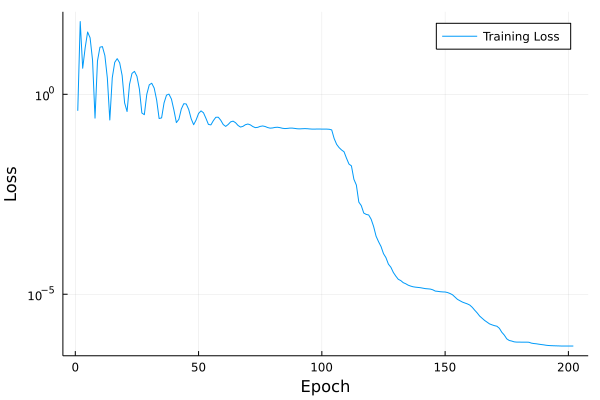

In [5]:
plot(losses, yaxis=:log, label = "Training Loss", xlabel="Epoch", ylabel="Loss")

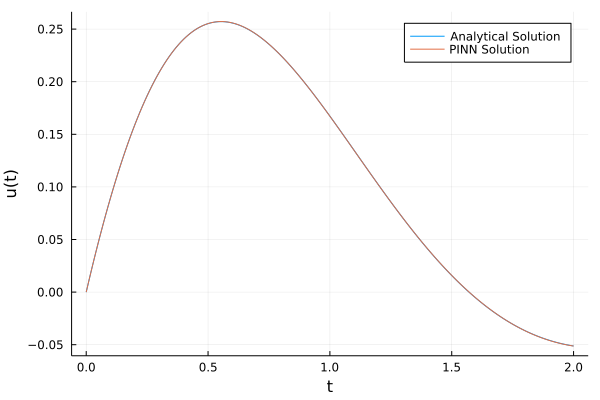

In [6]:
ts = [infimum(d.domain):0.01:supremum(d.domain) for d in domains][1]
phi = discretization.phi

u_predict  = [first(phi([t],res2.u)) for t in ts]
u_real  = [analytic_solution(t) for t in ts]

plot(ts ,u_real, label = "Analytical Solution",xlabel="t", ylabel="u(t)")
plot!(ts, u_predict, label = "PINN Solution")

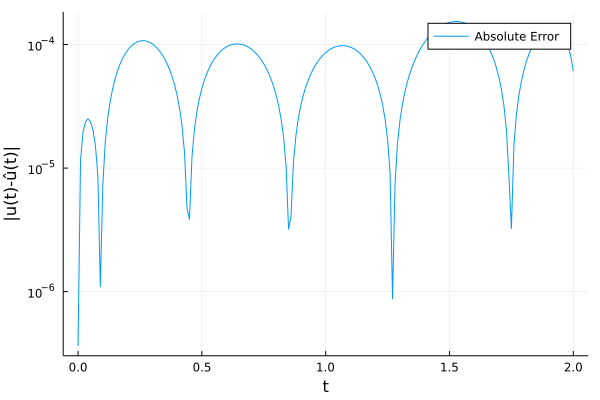

In [7]:
plot(ts ,abs.(u_real-u_predict), yaxis=:log, label = "Absolute Error",xlabel="t", ylabel="|u(t)-û(t)|")